In [25]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from models import LCALSTM as Agent
from task import SequenceLearning
from exp_tz import run_tz
from utils.params import P
from utils.constants import TZ_COND_DICT
from utils.io import build_log_path, load_ckpt, load_env_metadata
from analysis import compute_acc, compute_dk, compute_mistake, trim_data, \
    compute_cell_memory_similarity, create_sim_dict,  process_cache,\
    batch_compute_true_dk,  get_trial_cond_ids, compute_n_trials_to_skip,\
    compute_cell_memory_similarity_stats, sep_by_qsource, get_qsource
from analysis.task import get_oq_keys
from vis import plot_pred_acc_rcl, get_ylim_bonds
from matplotlib.ticker import FormatStrFormatter
sns.set(style='white', palette='colorblind', context='poster')
all_conds = TZ_COND_DICT.values()
seed = 0

# loading params
supervised_epoch = 600
epoch_load = 1000
n_branch = 4
n_param = 16
enc_size = 16
pad_len_load = -1
p_rm_ob_enc_load = .3
p_rm_ob_rcl_load = 0
def_prob = None
n_def_tps = 0
comp_val = .8
p_test = 0
p_rm_ob_enc_test = p_test
p_rm_ob_rcl_test = p_test
similarity_max_test = .9
similarity_min_test = 0
fix_cond = None

In [26]:
log_root = '../demo-log/'

exp_name = 'vary-training-penalty'
# exp_name = 'vary-test-penalty'
# exp_name = 'familiarity-signal'

n_examples_test = 256
attach_cond = 0
# testing params
# enc_size_test = 8
enc_size_test = enc_size
subj_id = 0
penalty_train = 4
penalty_test = 4

In [27]:
'''process the parameters, set up the task, load the network weights'''
p = P(
    exp_name=exp_name, sup_epoch=supervised_epoch,
    n_param=n_param, n_branch=n_branch, pad_len=pad_len_load,
    def_prob=def_prob, n_def_tps=n_def_tps,
    enc_size=enc_size, attach_cond=attach_cond,
    penalty=penalty_train,
    p_rm_ob_enc=p_rm_ob_enc_load, p_rm_ob_rcl=p_rm_ob_rcl_load,
)
# create logging dirs
log_path, log_subpath = build_log_path(
    subj_id, p, log_root=log_root, mkdir=False, verbose=True
)

# init env
env_data = load_env_metadata(log_subpath)
def_path = env_data['def_path']
p.env.def_path = def_path
p.update_enc_size(enc_size_test)

task = SequenceLearning(
    n_param=p.env.n_param, n_branch=p.env.n_branch,
    p_rm_ob_enc=p_rm_ob_enc_test, p_rm_ob_rcl=p_rm_ob_rcl_test,
    similarity_max=similarity_max_test, similarity_min=similarity_min_test,
    similarity_cap_lag=p.n_event_remember,
)
x_dim = task.x_dim
if attach_cond != 0:
    x_dim += 1
# load the agent back
agent = Agent(
    input_dim=x_dim, output_dim=p.a_dim,
    rnn_hidden_dim=p.net.n_hidden, dec_hidden_dim=p.net.n_hidden_dec,
    dict_len=p.net.dict_len
)
agent, optimizer = load_ckpt(epoch_load, log_subpath['ckpts'], agent)

Use exisiting dir: 
../demo-log/familiarity-signal/p-16_b-4_pad-random/tp-0.25/p_rm_ob_rcl-0.00_enc-0.30/lp-4/enc-cum_size-16/nmem-2/rp-LCA_metric-cosine/h-194_hdec-128/lr-0.0007-eta-0.1/sup_epoch-600/subj-0
- use exisiting sub dir: ckpts
- use exisiting sub dir: data
- use exisiting sub dir: figs
network weights - epoch 1000 loaded


In [28]:
'''Run the "twilight zone experiment" - this simulates the paradigm used in Janice Chen et al. 2016'''
np.random.seed(seed)
torch.manual_seed(seed)
[results, metrics, XY] = run_tz(
    agent, optimizer, task, p, n_examples_test,
    supervised=False, learning=False, get_data=True,
    fix_cond=fix_cond, fix_penalty=penalty_test
)

[dist_a_, Y_, log_cache_, log_cond_] = results
[X_raw, Y_raw] = XY

'''organize results to analyzable form'''
def_path_int = np.argmax(def_path, axis=1)
T_part = n_param
T_total = T_part * task.n_parts

# skip examples untill EM is loaded 
n_examples_skip = compute_n_trials_to_skip(log_cond_, p)
n_trials = n_examples_test - n_examples_skip
trial_id = np.arange(n_trials)

data_to_trim = [dist_a_, Y_, log_cond_, log_cache_, X_raw]
[dist_a, Y, log_cond, log_cache, X_raw] = trim_data(
    n_examples_skip, data_to_trim)
X_raw = np.array(X_raw)

# process the data
cond_ids = get_trial_cond_ids(log_cond)
[C, H, M, CM, DA, V], [inpt] = process_cache(
    log_cache, T_total, p)
comp = np.full(np.shape(inpt), comp_val)
leak = np.full(np.shape(inpt), 0)
# compute ground truth / objective uncertainty, delay phase removed
true_dk_wm, true_dk_em = batch_compute_true_dk(X_raw, task)
q_source = get_qsource(true_dk_em, true_dk_wm, cond_ids, p)

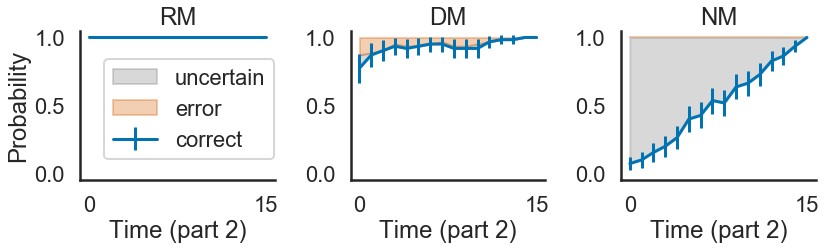

In [29]:
# compute performance
actions = np.argmax(dist_a, axis=-1)
targets = np.argmax(Y, axis=-1)
corrects = targets == actions
dks = actions == p.dk_id
mistakes = np.logical_and(targets != actions, ~dks)

# compute performance stats
for i, cn in enumerate(all_conds):
    Y_ = Y[cond_ids[cn], :]
    dist_a_ = dist_a[cond_ids[cn], :]
    # compute performance for this condition
    acc_mu, acc_er = compute_acc(Y_, dist_a_, return_er=True)
    dk_mu = compute_dk(dist_a_)
    mis_mu, mis_er = compute_mistake(
        Y_, dist_a_, return_er=True)

'''plot behavioral performance'''
f, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, cn in enumerate(['RM', 'DM', 'NM']):
    Y_ = Y[cond_ids[cn], :]
    dist_a_ = dist_a[cond_ids[cn], :]
    # compute performance for this condition
    acc_mu, acc_er = compute_acc(Y_, dist_a_, return_er=True)
    dk_mu = compute_dk(dist_a_)
    if i == 0:
        add_legend = True
        show_ylabel = True
        legend_loc = (.33, .7)
    else:
        add_legend = False
        show_ylabel = False
    # plot
    plot_pred_acc_rcl(
        acc_mu[T_part:], acc_er[T_part:],
        acc_mu[T_part:] + dk_mu[T_part:],
        p, f, axes[i],
        title=f'{cn}',
        add_legend=add_legend, legend_loc=legend_loc,
        show_ylabel=show_ylabel
    )
    axes[i].set_ylim([-.05, 1.05])

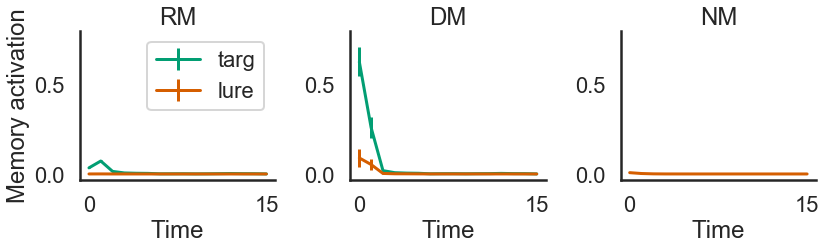

In [30]:
'''plot target/lure activation for all conditions - horizontal'''

lca_param_names = ['input gate', 'competition']
lca_param_records = [inpt, comp]

# compute similarity between cell state vs. memories
sim_cos, sim_lca = compute_cell_memory_similarity(
    C, V, inpt, leak, comp)
sim_lca_dict = create_sim_dict(
    sim_lca, cond_ids, n_targ=p.n_segments)
sim_lca_stats = compute_cell_memory_similarity_stats(
    sim_lca_dict, cond_ids)

memory_types = ['targ', 'lure']
avg_ma = {cond: {m_type: None for m_type in memory_types}
          for cond in all_conds}
for cond in all_conds:
    for m_type in memory_types:
        if sim_lca_dict[cond][m_type] is not None:
            avg_ma[cond][m_type] = np.mean(
                sim_lca_dict[cond][m_type], axis=-1)

gr_pal = sns.color_palette('colorblind')[2:4]
ylim_bonds = {'LCA': None, 'cosine': None}
ker_name, sim_stats_plt_ = 'LCA', sim_lca_stats

f, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, c_name in enumerate(cond_ids.keys()):
    for m_type in memory_types:
        if m_type == 'targ' and c_name == 'NM':
            continue
        color_ = gr_pal[0] if m_type == 'targ' else gr_pal[1]
        axes[i].errorbar(
            x=range(T_part),
            y=sim_stats_plt_[c_name][m_type]['mu'][T_part:],
            yerr=sim_stats_plt_[c_name][m_type]['er'][T_part:],
            label=f'{m_type}', color=color_
        )
        axes[i].set_title(c_name)
        axes[i].set_xlabel('Time')
axes[0].set_ylabel('Memory activation')
axes[0].legend()

# make all ylims the same
ylim_bonds[ker_name] = get_ylim_bonds(axes)
ylim_bonds[ker_name] = (
    np.max((ylim_bonds[ker_name][0], -.05)
           ), np.round((ylim_bonds[ker_name][1] + .1), decimals=1)
)
for i, ax in enumerate(axes):
    ax.set_ylim(ylim_bonds[ker_name])
    ax.set_xticks([0, p.env.n_param - 1])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
f.tight_layout()
sns.despine()

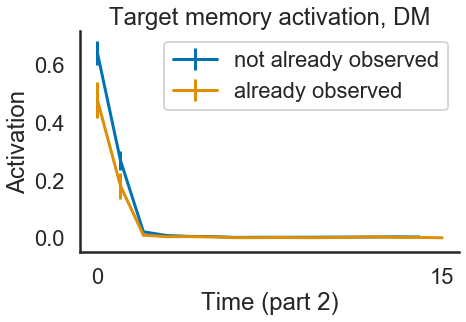

In [31]:
'''memory activation x uncertainty'''

DM_qsources = ['EM only', 'both']
n_se = 1
cond_name = 'DM'
targ_act_cond_p2_stats = sep_by_qsource(
    avg_ma[cond_name]['targ'][:, T_part:],
    q_source[cond_name], n_se=n_se
)
f, ax = plt.subplots(1, 1, figsize=(7, 5))
for key, [mu_, er_] in targ_act_cond_p2_stats.items():
    if not np.all(np.isnan(mu_)):
        ax.errorbar(x=range(n_param), y=mu_,
                    yerr=er_, label=key)
ax.set_title(f'Target memory activation, {cond_name}')
ax.set_xlabel('Time (part 2)')
ax.set_ylabel('Activation')
ax.set_ylim([-.05, None])
ax.set_xticks([0, p.env.n_param - 1])
ax.legend(['not already observed',
           'already observed'], fancybox=True)
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
f.tight_layout()
sns.despine()

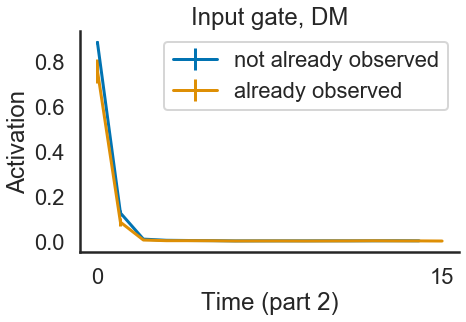

In [32]:
'''input gate x uncertainty'''
ig_cond_p2_stats = sep_by_qsource(
    lca_param_records[0][cond_ids[cond_name]][:, T_part:],
    q_source[cond_name], n_se=n_se
)
f, ax = plt.subplots(1, 1, figsize=(7, 5))
for key, [mu_, er_] in ig_cond_p2_stats.items():
    if not np.all(np.isnan(mu_)):
        ax.errorbar(x=range(n_param), y=mu_,
                    yerr=er_, label=key)
ax.set_title(f'Input gate, {cond_name}')
ax.set_xlabel('Time (part 2)')
ax.set_ylabel('Activation')
ax.set_ylim([-.05, None])
ax.set_xticks([0, p.env.n_param - 1])
ax.legend(['not already observed',
           'already observed'], fancybox=True)
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
f.tight_layout()
sns.despine()